# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [32]:
# initial imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import panel as pn
import plotly.express as px
from pathlib import Path
from dotenv import load_dotenv


# Initialize the Panel Extensions (for Plotly)
pn.extension('plotly')

In [33]:
# Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX")

# Import Data

In [34]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Data/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [35]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    
    housing_units_per_year = sfo_data.groupby(['year']).mean()['housing_units']
        
    housing_units_per_year_plot = plt.figure()
    housing_units_plot = housing_units_per_year.plot.bar(figsize=(10,10), x='Year', ylim=[360000,390000], y='Housing Units',
                                                                   title='Housing Units in San-Francisco from 2010 to 2016')
    plt.close(housing_units_per_year_plot)
     
    return pn.pane.Matplotlib(housing_units_per_year_plot)


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    average_gross_rent1 = pd.DataFrame(sfo_data.groupby(['year']).mean()['gross_rent'])
    average_gross_rent_plot = average_gross_rent1.hvplot(figsize=(10, 10), title ='Average gross rent per Year')
      
    return average_gross_rent_plot


def average_sales_price():
    """Average Sales Price Per Year."""
    
    average_price_sf1 = pd.DataFrame(sfo_data.groupby(['year']).mean()['sale_price_sqr_foot'])
    average_sales_price_plot = average_price_sf1.hvplot(figsize=(10, 10),title='Average Sales Price per Year' )
    
    return average_sales_price_plot


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    df_price = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    df_price.reset_index(inplace=True)
    df_price.rename(columns={"level_0": "year"}, inplace=True)
    average_price_by_neighborhood_plot = df_price.hvplot.line(
    "year",
    "sale_price_sqr_foot",
    xlabel="Year",
    ylabel="Average Sale Price per SQF",
    groupby="neighborhood",)
    
    return average_price_by_neighborhood_plot


def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    df_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(by="sale_price_sqr_foot", ascending=False).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()
    df_expensive_neighborhoods
    
    
    top_most_expensive_neighborhoods_plot = df_expensive_neighborhoods.hvplot.bar(
    "neighborhood",
    "sale_price_sqr_foot",
    title="Top 10 Expensive Neighborhoods in San Francisco",
    xlabel="Neighborhood",
    ylabel="Average Sale Price per SQF",
    height=400,
    rot=90)
    
    return top_most_expensive_neighborhoods_plot


def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    df_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(by="sale_price_sqr_foot", ascending=False).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()
    df_expensive_neighborhoods
   
    parallel_coordinates_plot = px.parallel_coordinates(
    df_expensive_neighborhoods,
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    title='Average Values per Neighborhood',
    labels={'neighborhood': "Neighborhood", 
            'sale_price_sqr_foot':'Sales Price per SQF',
           'housing_units':'Housing Units',
           'gross_rent':'Gross rent'},)
    
    return parallel_coordinates_plot


def parallel_categories():
    """Parallel Categories Plot."""
    
    df_expensive_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_expensive_neighborhoods = df_expensive_neighborhoods.sort_values(by="sale_price_sqr_foot", ascending=False).head(10)
    df_expensive_neighborhoods = df_expensive_neighborhoods.reset_index()
    df_expensive_neighborhoods
    
    parallel_categories_plot = px.parallel_categories(
    df_expensive_neighborhoods,
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
    title='Average Values per Neighborhood',
    labels={'neighborhood': "Neighborhood", 
            'sale_price_sqr_foot':'Sales Price per SQF',
           'housing_units':'Housing Units',
           'gross_rent':'Gross Rent'},) 
       
    
    return parallel_categories_plot


def neighborhood_map():
    """Neighborhood Map"""
    
    df_neighborhoods = sfo_data.groupby(by="neighborhood").mean()
    df_neighborhoods = df_neighborhoods.sort_values(by="sale_price_sqr_foot", ascending=False)
    df_neighborhoods = df_neighborhoods.reset_index()
    df_all_neighborhoods=pd.concat([df_neighborhood_locations,
                                df_neighborhoods['sale_price_sqr_foot'],
                                df_neighborhoods['housing_units'],
                                df_neighborhoods['gross_rent']
                               ], axis=1).dropna()
    
    
    map = px.scatter_mapbox(
        df_all_neighborhoods,
        lat="Lat",
        lon="Lon",
        size="sale_price_sqr_foot",
        color="gross_rent",
        color_continuous_scale=px.colors.cyclical.IceFire,
        size_max=15,
        zoom=11,
        hover_name="Neighborhood",
        title="Averange Sale Price Per Square Foot and Gross Rent in San Francisco",
        width=960,
        height=600
    )
    plotly_panel = pn.pane.Plotly(map)
    plotly_panel._updates = True
    return plotly_panel


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [36]:
title = pn.pane.Markdown(
    """
# Real Estate Market Analysis of San Francisco in 2010 - 2016
""",
    width=800,
)
welcome = pn.pane.Markdown(
    """
This dashboard presents a visual analysis of historical prices of house units,
sale price per square foot and gross rent in San Francisco, California
from 2010 to 2016.
"""
)
# Create a tab layout for the dashboard
tabs = pn.Tabs(
    ("Welcome", pn.Column(welcome, neighborhood_map())),
    ("Yearly Market Analysis", pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())),
    ("Neighborhood Analysis", pn.Column(average_price_by_neighborhood(), top_most_expensive_neighborhoods())),
    (
        "Parallel Plots Analysis",
        pn.Column(parallel_coordinates(), parallel_categories(), width=960),
    ),
)
panel = pn.Column(pn.Row(title), tabs, width=900)

## Serve the Panel Dashboard

Column(width=900)
    [0] Row
        [0] Markdown(str, width=800)
    [1] Tabs
        [0] Column
            [0] Markdown(str)
            [1] Plotly(Figure)
        [1] Row
            [0] Matplotlib(Figure)
            [1] HoloViews(Curve)
            [2] HoloViews(Curve)
        [2] Column
            [0] Row
                [0] HoloViews(DynamicMap)
                [1] Column
                    [0] WidgetBox
                        [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                    [1] VSpacer()
            [1] HoloViews(Bars)
        [3] Column(width=960)
            [0] Plotly(Figure)
            [1] Plotly(Figure)
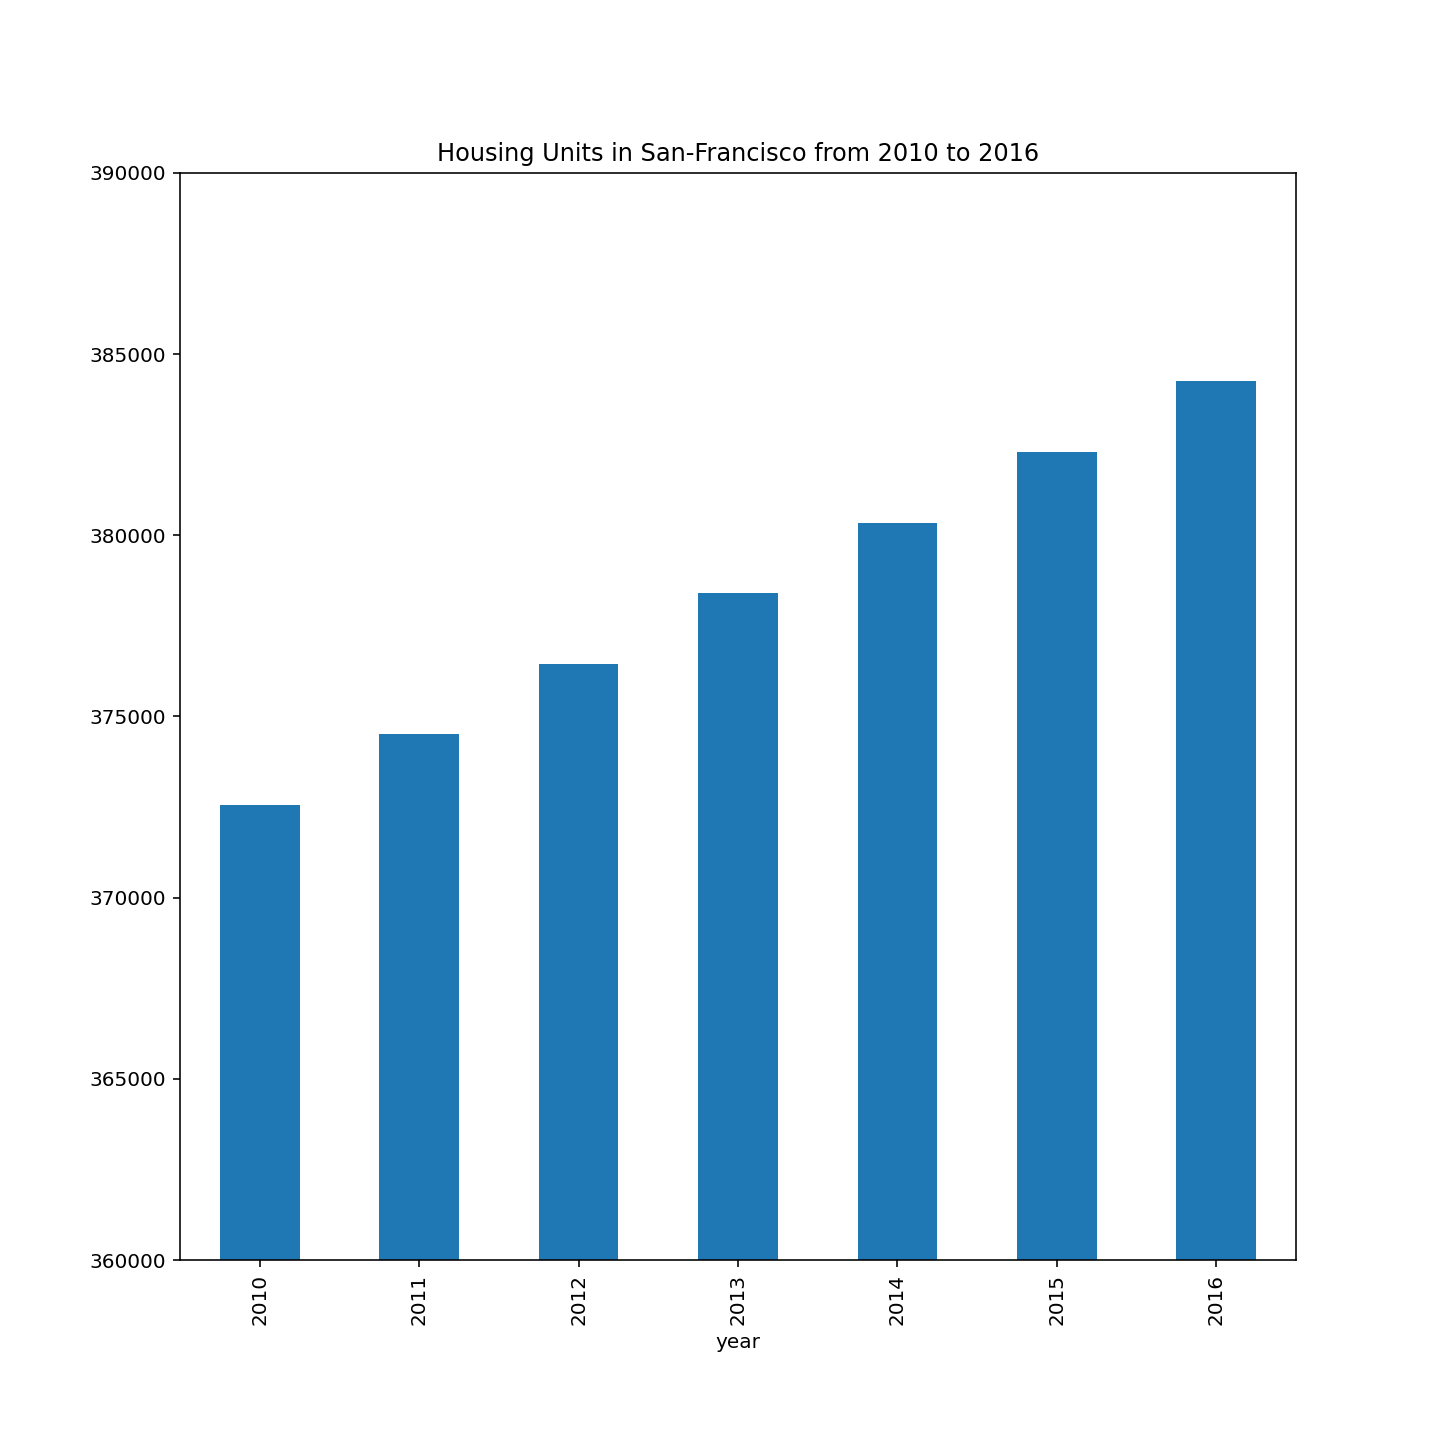

In [37]:
panel.servable()